In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

#from tensorflow.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

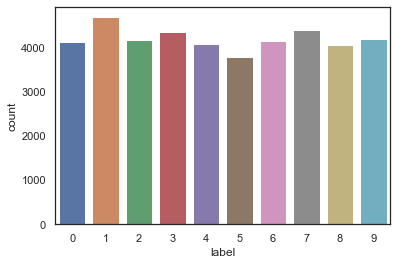

In [5]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

g = sns.countplot(Y_train)

Y_train.value_counts()

In [6]:
# Check the data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [7]:
X_train = X_train / 255.0
test = test / 255.0

In [8]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [12]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
train_y_list = list(Y_train)

train_y_ = np.zeros((len(train_y_list), 10))

for i in range(len(train_y_list)):
    train_y_[i, train_y_list[i]] = 1
    
train_y_DF = pd.DataFrame(train_y_, columns = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Y_train=train_y_DF.values

In [14]:
# Set the random seed
random_seed = 2

# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

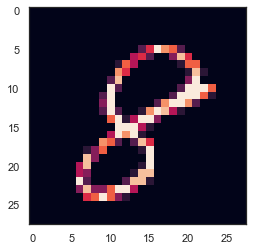

In [15]:
# Some examples
g = plt.imshow(X_train[0][:,:,0])

In [16]:
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [17]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [18]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [19]:
epochs = 30 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

In [20]:
# Without data augmentation i obtained an accuracy of 0.98114
#history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
#          validation_data = (X_val, Y_val), verbose = 2)

# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [21]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
Epoch 1/30
4200/439 - 5s - loss: 0.0487 - acc: 0.9807
439/439 - 222s - loss: 0.4048 - acc: 0.8711 - val_loss: 0.0613 - val_acc: 0.9807
Epoch 2/30
Epoch 1/30
4200/439 - 4s - loss: 0.0222 - acc: 0.9879
439/439 - 230s - loss: 0.1289 - acc: 0.9619 - val_loss: 0.0381 - val_acc: 0.9879
Epoch 3/30
Epoch 1/30
4200/439 - 4s - loss: 0.0408 - acc: 0.9838
439/439 - 217s - loss: 0.1009 - acc: 0.9708 - val_loss: 0.0566 - val_acc: 0.9838
Epoch 4/30
Epoch 1/30
4200/439 - 5s - loss: 0.0263 - acc: 0.9902
439/439 - 225s - loss: 0.0808 - acc: 0.9758 - val_loss: 0.0296 - val_acc: 0.9902
Epoch 5/30
Epoch 1/30
4200/439 - 4s - loss: 0.0133 - acc: 0.9924
439/439 - 243s - loss: 0.0755 - acc: 0.9787 - val_loss: 0.0227 - val_acc: 0.9924
Epoch 6/30
Epoch 1/30
4200/439 - 5s - loss: 0.0173 - acc: 0.9914
439/439 - 228s - loss: 0.0705 - acc: 0.9795 - val_loss: 0.0299 - val_acc: 0.9914
Epoch 7/30
Epoch 1/30
4200/439 - 4s - loss: 0.0133 - acc: 0.9921
439/439 - 222s - loss: 0.0650 - acc: 0.9811 - val_loss: 0.0

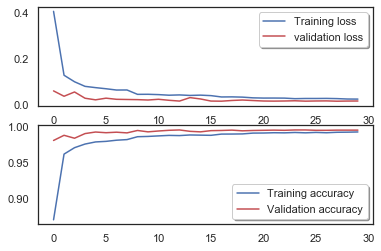

In [22]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [23]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [24]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("CNN.csv",index=False)

In [50]:
x

array([[[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14]],

       [[15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24],
        [25, 26, 27, 28, 29]]])

In [49]:
x.shape

(2, 3, 5)

In [61]:
x[:,:,-1]

array([[ 4,  9, 14],
       [19, 24, 29]])

In [46]:
y[np.array([0,2,4])]

array([[ 0,  1,  2,  3,  4,  5,  6],
       [14, 15, 16, 17, 18, 19, 20],
       [28, 29, 30, 31, 32, 33, 34]])